###  Libraries

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.clustering import KernelKMeans as TSKernelKMeans
from KernelKMeans import KernelKMeans
from GlobalKernelKMeans import GlobalKernelKMeans, GlobalKernelKMeansPP 
from Datasets.Datasets_Functions import *
from Rings import Rings
from Common_Modules.Evaluation import Evaluator
from Common_Modules.Graph import Graph
from Common_Modules.Visualization import Visualization
from Common_Modules.General_Functions import General_Functions

### Switches

In [2]:
plot_is_enabled = True
two_rings_is_enabled = False
three_rings_is_enabled = False
one_ring_with_two_gaussians_is_enabled = True
three_rings_paper_is_enabled = False
graph_is_enabled = False
real_dataset_is_enabled = False
kMeans_is_enabled = False
kernelKMeans_is_enabled = False
kernelKMeansPP_is_enabled = True
globalKernelKMeans_is_enabled = True
globalKernelKMeansPP_is_enabled = True

### Global Variables

In [3]:
seed = 42
evaluator = Evaluator()
n_candidates = n_init = 100
kernels = ["cosine", "laplacian", "rbf"]
kernel = kernels[2]
gamma = 1.0

### Visualization

In [4]:
visualization = Visualization()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

### Load Dataset

### 2Rings

In [5]:
if(two_rings_is_enabled):
    centers_coordinates = [(-2, 2), (2, 2), (6, 2), (5, 6), (-1, 6), (2, 10), (5, -2), (2, -6), (-1, -2)]
    
    #centers_coordinates = [(-2, 2), (2, 2), (6, 2), (2, 10), (2, -6)]
    
    #centers_coordinates = [(-1, 2), (2, 2)]
    rings = Rings()
    
    X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=100, factor=0.2, noise=0.0)
        
    K = 2 * len(centers_coordinates)
    print(K)
    kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=1)
    dataset_name = f"{K}Rings"
    data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
    General_Functions().create_directory(data_dir_path)
    visualization.plot(X, y, data_dir_path=f"{data_dir_path}Generated.png")

### 3Rings

In [6]:
if (three_rings_is_enabled):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    rings = Rings()

    centers_coordinates = [(0, 0)]
    X, y = rings.make_concentric_rings(centers_coordinates=centers_coordinates, n_samples=150, radii=[1, 10, 25], noise=0)
    
    K = 3 * len(centers_coordinates)
    kernel_matrix = pairwise_kernels(X, X, metric='sigmoid')

### 1 Ring with 2 Gaussians Inside

In [ ]:
if(one_ring_with_two_gaussians_is_enabled):
    rings = Rings()
    centers_coordinates = [(0, 0), (20, 0)]
    X, y = rings.make_multiple_rings_with_gaussians(centers_coordinates, n_samples=50, radius=5, noise=0.0, gaussian_samples=30)
    X, y = rings.make_spiral(n_samples=100, noise=0.0, n_turns=1)
    
    K = 2 #4 * len(centers_coordinates)
        
    #gamma = General_Functions.calculate_gamma_scale(X)
    #gamma = 1/X.shape[1]
    kernel = kernels[2]
    print(gamma)
    kernel_matrix = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    dataset_name = f"{int(K/3)}Rings_{int((2*K)/3)}Gaussians"
    data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
    General_Functions().create_directory(data_dir_path)
    visualization.plot(X, y, data_dir_path=f"{data_dir_path}Generated.png")
    print(len(y))

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

class MoonsInRings:
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(self.seed)
    
    def generate_ring(self, n_samples, radius, noise):
        angles = np.linspace(0, 2 * np.pi, n_samples, endpoint=False)
        X = np.c_[radius * np.cos(angles), radius * np.sin(angles)]
        X += noise * np.random.randn(n_samples, 2)
        return X
    
    def generate_moons(self, n_samples, noise):
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=self.seed)
        return X, y

    def move_data(self, X, shift):
        """Move data by a certain amount (shift)."""
        X[:, 0] += shift[0]
        X[:, 1] += shift[1]
        return X

    def make_moons_in_rings(self, centers_coordinates, ring_radius=2, moon_samples=200, ring_samples=100, moon_noise=0.1, ring_noise=0.05):
        X_list, y_list = [], []
        label_offset = 0
        
        for center_coordinates in centers_coordinates:
            # Generate a ring for the current center
            X_ring = self.generate_ring(ring_samples, ring_radius, ring_noise)
            y_ring = np.full(X_ring.shape[0], label_offset)
            X_ring = self.move_data(X_ring, center_coordinates)
            
            # Generate moons inside the ring
            X_moons, y_moons = self.generate_moons(moon_samples, moon_noise)
            X_moons = self.move_data(X_moons, center_coordinates)  # Move moons to the ring center
            
            # Append to the dataset
            X_list.append(X_ring)
            y_list.append(y_ring)
            X_list.append(X_moons)
            y_list.append(y_moons + label_offset)  # Adjust moon labels to avoid overlap

            label_offset += 2  # Two labels for each moon pair
        
        X = np.concatenate(X_list)
        y = np.concatenate(y_list)
        return X, y

# Example usage
moons_in_rings = MoonsInRings()
centers = [(0, 0)]  # Two rings centered at (0,0) and (5,5)

# Generate the moons-in-rings dataset
X, y = moons_in_rings.make_moons_in_rings(centers, ring_radius=3, moon_samples=200, ring_samples=100, moon_noise=0.1, ring_noise=0.05)
    
#gamma = General_Functions.calculate_gamma_scale(X)
gamma = 1/X.shape[1]
kernel_matrix = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
K = 3

### 3Rings Paper

In [9]:
if (three_rings_paper_is_enabled):
    rings = Rings(colors=colors)
    K = 3
    X, y, kernel_matrix = rings.global_kernel_k_means_three_rings()
    rings.plot(X,y)

### Graphs

In [10]:
if(graph_is_enabled):
    K = 10
    graph = Graph(n_communities=K, n_nodes_per_community=10, p_intra=1, p_inter=0.01, colors=colors)
    dataset_name = f"Graph_NPC_{graph.n_nodes_per_community}_PIntra_{graph.p_intra}_PInter_{graph.p_inter}"
    graph.create_adj_matrix()
    kernel_matrix = graph.adj_matrix = pairwise_kernels(graph.adj_matrix, graph.adj_matrix, metric='linear')
    data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
    General_Functions.create_directory(data_dir_path)

### Real Dataset

In [11]:
if (real_dataset_is_enabled):
    dataset_names = ["breast_cancer", "dermatology", "ecoli", "iris", "olivetti_faces", "pendigits", "waveform_v1", "wine"]
    dataset_name = dataset_names[0] 
    module_name = "Datasets.Datasets"
    batch_size = 16
    dataloader, input_dim, X, y = function_get_dataset(dataset_name, module_name, batch_size)
    print('Date Number is:', len(y))
    print('Data_Shape is:', input_dim)
    K = len(np.unique(y))
    gamma = General_Functions.calculate_gamma_scale(X)
    kernel_matrix = pairwise_kernels(X, X, metric=kernel)
    data_dir_path = f"Results\\{dataset_name}\\{kernel}\\{n_init}\\"
    General_Functions().create_directory(data_dir_path)
    K = 50

### kMeans

In [12]:
if(kMeans_is_enabled):
    kmeans = KMeans(n_clusters=K).fit(X)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
    evaluator.print_evaluation()
    if(plot_is_enabled):
        visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans

In [13]:
if(kernelKMeans_is_enabled):
    kernel_kmeans = TSKernelKMeans(n_clusters=K, n_init=10, kernel='precomputed').fit(kernel_matrix)
    acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
    evaluator.print_evaluation()
    if(plot_is_enabled):
        visualization.plot_tsne(X, y, data_dir_path="Figures\\"+dataset_name)

### Kernel kMeans++

In [ ]:
if(kernelKMeansPP_is_enabled):
    initialization_methods = ["forgy", "random", "k-means++"]
    n_iters_ = {}
    execution_times_ = {}
    inertias_ = {}
    init = initialization_methods[2]
    prev_K = K
    K = K
    while (K != prev_K + 1):
        kernelKMeans = KernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, n_init=n_init, init=init, verbose=0)
        kernelKMeans.fit()
        
        if(plot_is_enabled):
            if graph_is_enabled:
                graph.plot_clusters(kernelKMeans.labels_)
            else:
                visualization.plot(X, kernelKMeans.labels_, data_dir_path=data_dir_path + "KernelKMeans_" + init)                
        
        n_iters_[K] = sum(kernelKMeans.n_iters_.values())
        execution_times_[K] = sum(kernelKMeans.execution_times_.values())
        inertias_[K] = kernelKMeans.inertia_
        new_row = { "K": K, "MSE": inertias_[K], "ITERATIONS": n_iters_[K], "EXECUTION TIME": execution_times_[K]}
        General_Functions.append_to_csv(f"{data_dir_path}KernelKMeans_Dataset_{dataset_name}_Init_{init}_Kernel_{kernel}_K_{prev_K}_Inits_{n_init}_Results.csv", new_row)
        K += 1
    K = prev_K   

### Global Kernel kMeans

In [ ]:
if(globalKernelKMeans_is_enabled):
    globalKernelKMeans = GlobalKernelKMeans(n_clusters=K, kernel_matrix=kernel_matrix, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeans.fit()
    
    if(plot_is_enabled):
        if graph_is_enabled:
            graph.plot_clusters(globalKernelKMeans.labels_[K])
        else:
            visualization.plot(X, globalKernelKMeans.labels_[K], data_dir_path=f"{data_dir_path}GlobalKernelKMeans")

### Global Kernel kMeans++

Solved 2-means MSE: 150.37462277003198 in 0.22247791290283203s
Solving 3-means
Solved 3-means MSE: 118.25096210353348 in 0.18903303146362305s
Total execution time was 0.4115109443664551s


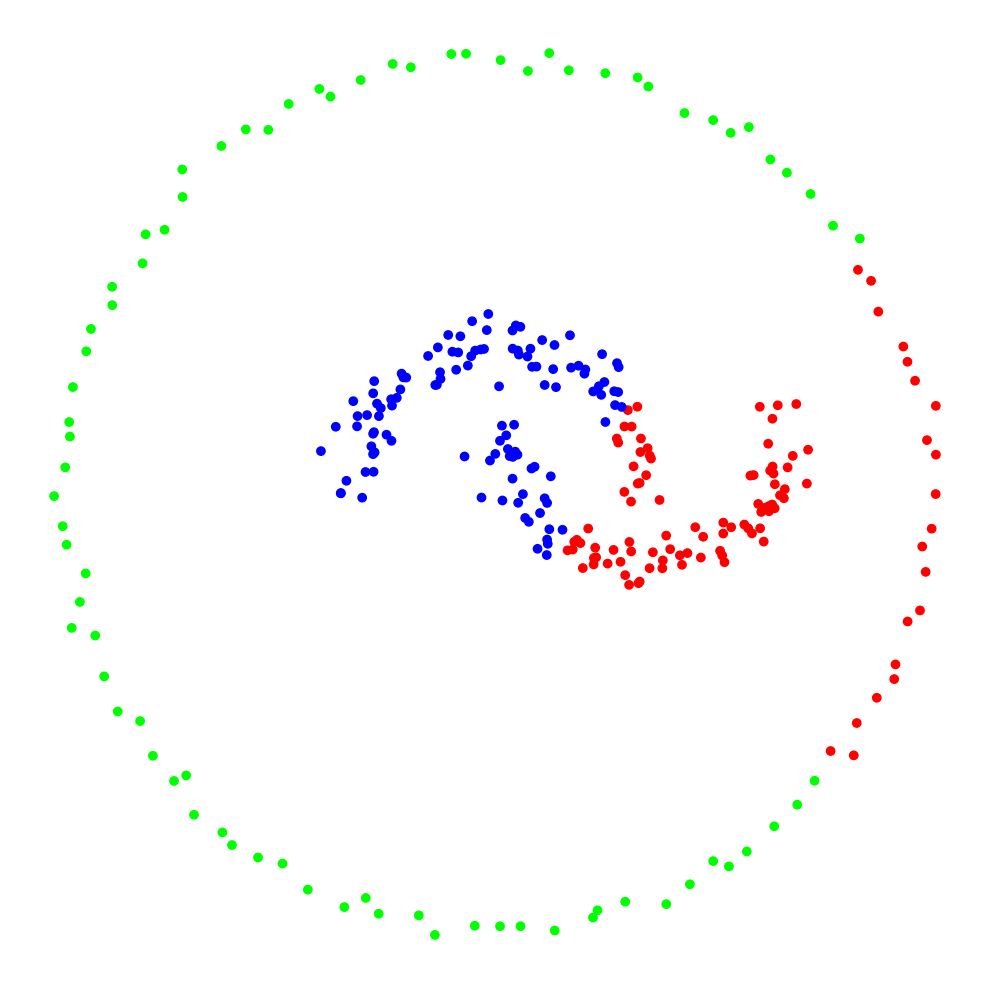

In [16]:
if(globalKernelKMeansPP_is_enabled):
    sampling_methods = ["sequential", "batch"]
    sampling = sampling_methods[0] 
    globalKernelKMeansPP = GlobalKernelKMeansPP(n_clusters=K, kernel_matrix=kernel_matrix, n_candidates=30, sampling=sampling, data_dir_path=f"{data_dir_path}GlobalKernelKMeans_Dataset_{dataset_name}_Sampling_{sampling}_Kernel_{kernel}_K_{K}_Inits_{n_init}_Results.csv", verbose=1)
    globalKernelKMeansPP.fit()
    
    #acc, pur, nmi, ari = evaluator.evaluate_model(y, globalKernelKMeansPP.labels_[K])
    if(plot_is_enabled):
        if graph_is_enabled:
            graph.plot_clusters(globalKernelKMeansPP.labels_[K])
        else:
            visualization.plot(X, globalKernelKMeansPP.labels_[K], data_dir_path=f"{data_dir_path}GlobalKernelKMeans_{sampling}_")